# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
    
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

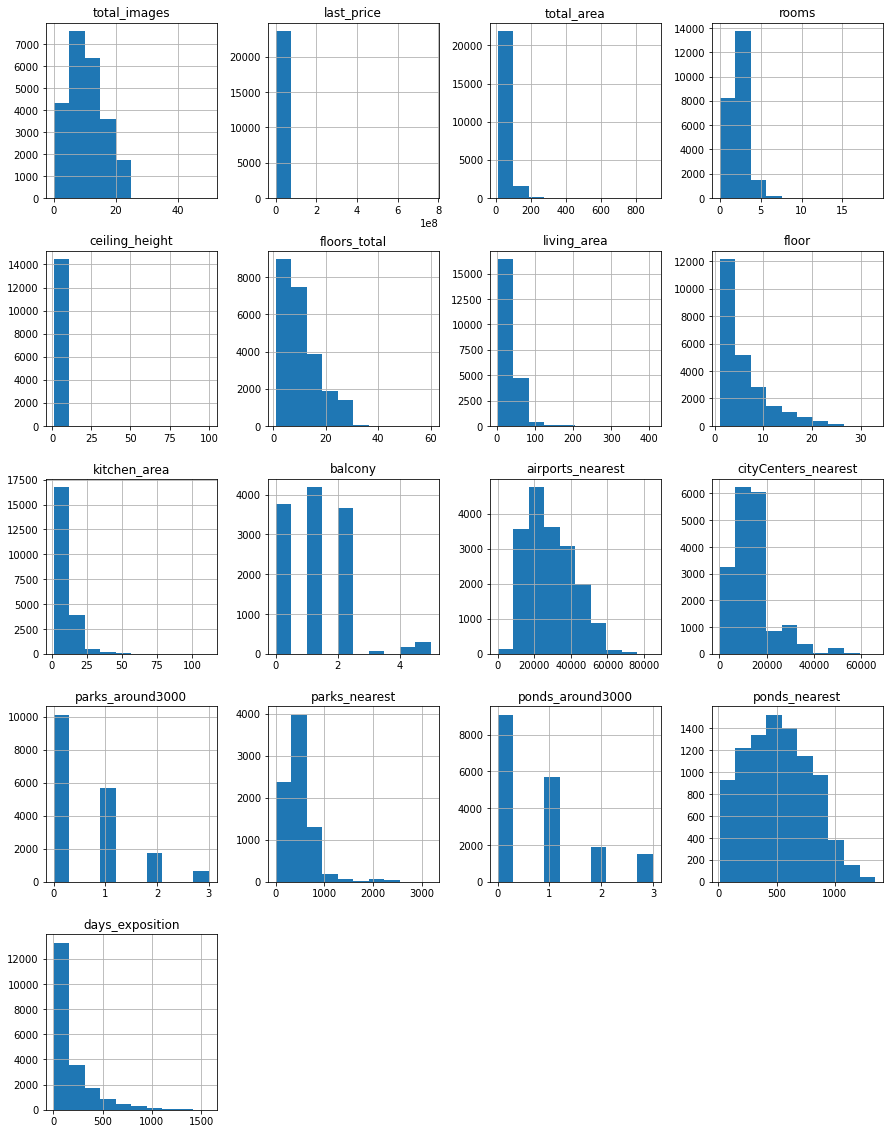

In [4]:
# построим гистограммы для всех столбцов таблицы
data.hist(figsize=(15, 20));

In [5]:
# проверим наличие явнях дубликатов в данных
data.duplicated().sum()

0

### 2. Предобработка данных

#### 2.1. Найдите и изучите пропущенные значения в столбцах

In [6]:
# посмотрим на количество пропусков  в данных
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски в колонках floors_total и locality_name вряд ли получится заполнить на основании других данных таблицы, таких пропусков не слишком много (меньше 1% от общего объема данных), эти строки можно удалить.

In [7]:
data = data.dropna(subset=['locality_name', 'floors_total'])

In [8]:
# поставим нули там, где не указано количество балконов
data['balcony'] = data['balcony'].fillna(0)

Постараемся заполнить пропуски в некоторых столбцах опираясь на присутствующие в данных корреляции.

In [9]:
# смотрим корреляцию ceiling_height с другими параметрами
data.corr().ceiling_height

total_images          -0.001865
last_price             0.085401
total_area             0.095432
rooms                  0.054378
ceiling_height         1.000000
floors_total          -0.028586
living_area            0.090573
floor                 -0.011685
studio                 0.001686
open_plan              0.042785
kitchen_area           0.087723
balcony                0.031370
airports_nearest      -0.023798
cityCenters_nearest   -0.091484
parks_around3000       0.065992
parks_nearest         -0.019307
ponds_around3000       0.078297
ponds_nearest         -0.059438
days_exposition        0.019027
Name: ceiling_height, dtype: float64

Явно выраженной корреляции между ceiling_height и другими переменными обнаружить не удалось.
<br/> 
<br/> Для заполения пропусков в ceiling_height попробуем использовать столбец locality_name. Сгруппируем данные по названию населенного пункта и найдем медианное значение высоты потолков в каждом населенном пункте.
*** 
Однако, сначала проверим названия населенных пунктов на присутствие неявных дубликатов.

#### 2.2. Изучите уникальные значения в столбце с названиями и устраните неявные дубликаты.

In [10]:
# проверим locality_name на неявные дубликаты, отсортируем в алфавитном порядке
np.sort(data.locality_name.unique())

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Обнаруживаем большое количество неявных дубликатов (попеременное исползование "е" и "ё" в названиях, различные обозначения типов для одного того же названия населенного пункта).

In [11]:
# посмотрим на количество унакальных значений в столбце 'locality_name'
data.locality_name.nunique()

364

In [12]:
# исправим все 'ё' на 'е'
data['locality_name'] = data['locality_name'].str.replace('ё','е')

# обозначения типов населенных пунктов в названиях опустим
to_replace = {
    r'(\b)поселок городского типа имени (\b)': r'',
    r'(\b)поселок городского типа (\b)': r'',
    r'(\b)городской поселок (\b)': r'',
    r'(\b)поселок при железнодорожной станции (\b)': r'',
    r'(\b)поселок станции (\b)': r'',
    r'(\b)коттеджный поселок (\b)': r'',
    r'(\b)деревня (\b)': r'',
    r'(\b)поселок (\b)': r'',
    r'(\b)садоводческое некоммерческое товарищество (\b)': r'',
    r'(\b)садовое товарищество (\b)': r'',
    r'(\b)село (\b)': r''    
}

data['locality_name'] = data['locality_name'].replace(to_replace, regex=True)

In [13]:
data.locality_name.nunique()

305

Таким образом нам удалось избавиться от 59 вариантов неявного дублирования.
***
Вернемся к заполению пропусков в данных.

In [14]:
# напишем функцию, которая будет считать медиану ceiling_height и заполнять пропуски в данных
def ceiling_height_filler(data):
    try:
        median = data.ceiling_height.median()
        data.loc[pd.isna(data.ceiling_height), 'ceiling_height'] = median
        return data
    except:
        pass

In [15]:
# применим функцию ceiling_height_filler для данных, сгруппированных по названиям населённых пунктов (locality_name)
data = data.groupby('locality_name').apply(ceiling_height_filler)

# проверим, остались ли незаполненные ячейки и сколько их
data[data['ceiling_height'].isna()==True].locality_name.count()

95

Для 95 незаполенных ячеек невозможно посчитать медиану исходя из названия населенного пункта (нет предложений в таком населенном пункте, где была бы указана высота потолка). Эти пропуски пока оставим, они будут исключены позже в ходе очистки данных от выбросов.

In [16]:
# смотрим корреляцию living_area с другими параметрами
data.corr().living_area

total_images           0.105551
last_price             0.566380
total_area             0.939771
rooms                  0.846117
ceiling_height         0.077771
floors_total          -0.168940
living_area            1.000000
floor                 -0.096676
studio                -0.056307
open_plan             -0.033756
kitchen_area           0.428909
balcony               -0.014786
airports_nearest      -0.057428
cityCenters_nearest   -0.230576
parks_around3000       0.184878
parks_nearest         -0.050694
ponds_around3000       0.149785
ponds_nearest         -0.082830
days_exposition        0.142135
Name: living_area, dtype: float64

Исходя из представленных данных, видим сильную положительную корреляцию между living_area и параметрами total_area и rooms. Для заполнения пропусков сгруппируем все квартиры по количеству комнат и заполним пропуски living_area медианами по группе. 

In [17]:
# напишем функцию, которая будет считать медиану living_area 
def living_area_filler(data):
    try:
        median = data.living_area.median()
        data.loc[pd.isna(data.living_area), 'living_area'] = median
        return data
    except:
        pass

In [18]:
# применим функцию living_area_filler для данных, сгруппированных по количеству комнат (rooms)
data = data.groupby('rooms').apply(living_area_filler)

In [19]:
# смотрим корреляцию kitchen_area с другими параметрами
data.corr().kitchen_area

total_images           0.106896
last_price             0.520362
total_area             0.609248
rooms                  0.270342
ceiling_height         0.073571
floors_total           0.164803
living_area            0.424321
floor                  0.136545
studio                      NaN
open_plan                   NaN
kitchen_area           1.000000
balcony                0.046207
airports_nearest       0.007797
cityCenters_nearest   -0.191140
parks_around3000       0.088512
parks_nearest          0.029578
ponds_around3000       0.151156
ponds_nearest         -0.104674
days_exposition        0.101071
Name: kitchen_area, dtype: float64

Попробуем заполнить пропуски в ячейках kitchen_area в соответствии с общей площадью квартиры: посчитаем, сколько в среднем kitchen_area составляет от total_area и для каждого пропуска в kitchen_area высчитаем значение согласно полученному коэффициенту.

In [20]:
# считаем сколько долей в среднем площадь кухни составляет от площади квартиры
kitchen_total_ratio = data[data['kitchen_area'].isna()==False].kitchen_area.mean()/data[data['kitchen_area'].isna()==False].total_area.mean()
print('Пересчетный коэффициент:', kitchen_total_ratio)

Пересчетный коэффициент: 0.17396342643072965


In [21]:
# напишем функцию, которая заменит NaN в 'kitchen_area' на значение из 'total_area' умноженное на ~0.174(kitchen_total_ratio)
def kitchen_fix_nan(row):
        if row['kitchen_area'] != row['kitchen_area']:
            row['kitchen_area'] = row['total_area'] * kitchen_total_ratio
        return row

data = data.apply(kitchen_fix_nan, axis=1)

#### 2.3. Рассмотрите типы данных в каждом столбце

In [22]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

Согласно описанию данных, 'is_apartment' должен хранить булевую переменную для обозначения, являтся ли данная квартира апартаментами. В выгрузке тип данных этого столбца - object.

In [23]:
# приведем столбец is_apartment к булевому типу и заполним пропуски значением False
data['is_apartment'] = data['is_apartment'].fillna(False).astype('bool')

Количество этажей в здании нет смысла хранить в формате числа с плавающей точкой - это должен быть целочисленный тип.

In [24]:
# приведем значения 'floors_total' к типу 'int'
data['floors_total'] = data['floors_total'].astype('int64')

In [25]:
# приведем значения в столбце first_day_exposition к формату даты
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Данный столбец хранит информацию о дате (должен быть datetime64[ns]), в выгрузке формат - object.

In [26]:
# изучаем общую информацию о данных после предварительной обработки
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23470 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

In [27]:
# смотрим, в каких столбцах остались неисправленные пропуски
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height             95
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

Оставшиеся в данных пропуски возникли, скорее всего, из-за того, что указанные поля были необязательные при заполнении пользователями, или из-за того, что при выгрузке данных произошли ошибки. Исправить эти пропуски не представляется возможным.

In [28]:
# сохраним количество строк в предобработанном датафрейме (это значение понадобится нам позже)
df_row_number = data.shape[0]
print(df_row_number)

23565


#### 2.4. Найдите и устраните редкие и выбивающиеся значения.

In [29]:
# посмотрим, какие уикальные значения указаны в столбце 'ceiling_height'
np.sort(data.ceiling_height.unique())

array([  1.   ,   1.2  ,   1.75 ,   2.   ,   2.2  ,   2.25 ,   2.3  ,
         2.34 ,   2.4  ,   2.45 ,   2.46 ,   2.47 ,   2.48 ,   2.49 ,
         2.5  ,   2.51 ,   2.52 ,   2.525,   2.53 ,   2.54 ,   2.55 ,
         2.56 ,   2.56 ,   2.57 ,   2.575,   2.58 ,   2.59 ,   2.6  ,
         2.6  ,   2.61 ,   2.615,   2.62 ,   2.625,   2.63 ,   2.64 ,
         2.65 ,   2.65 ,   2.66 ,   2.67 ,   2.675,   2.68 ,   2.69 ,
         2.7  ,   2.71 ,   2.72 ,   2.725,   2.73 ,   2.74 ,   2.75 ,
         2.76 ,   2.77 ,   2.78 ,   2.79 ,   2.8  ,   2.81 ,   2.82 ,
         2.83 ,   2.84 ,   2.85 ,   2.86 ,   2.87 ,   2.88 ,   2.89 ,
         2.9  ,   2.91 ,   2.92 ,   2.93 ,   2.94 ,   2.95 ,   2.96 ,
         2.97 ,   2.98 ,   2.99 ,   3.   ,   3.01 ,   3.02 ,   3.03 ,
         3.04 ,   3.05 ,   3.06 ,   3.07 ,   3.08 ,   3.09 ,   3.1  ,
         3.11 ,   3.12 ,   3.13 ,   3.14 ,   3.15 ,   3.16 ,   3.17 ,
         3.18 ,   3.2  ,   3.21 ,   3.22 ,   3.23 ,   3.24 ,   3.25 ,
         3.26 ,   3.

In [30]:
# посмотрим на описательные статистики для 'ceiling_height'
data.ceiling_height.describe()

count    23470.000000
mean         2.732281
std          1.006456
min          1.000000
25%          2.550000
50%          2.700000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

Предположим, что значения из столбца 'ceiling_height', которые превышают 22м - результат ошибки заполнения данных пользователями. Такие значения уменьшим в 10 раз. Теперь "нормальными" будем считать квартиры с высотой потолков не ниже 2.34м и не выше 3.5м. Строки, содержащие значения не попадающие в указанный диапазон, удалим.

In [31]:
# напишем функцию, которая все значения от 22 до 50 уменьшит в 10 раз, а затем оставит только результаты в пределах [2.34, 3.5)
def ceiling_height_fixer(ceiling_height):
        if 50 > ceiling_height > 22:
            ceiling_height * 0.1
        if 2.34 <= ceiling_height < 3.5:
            return ceiling_height
        else:
            return 0
    
data['ceiling_height'] = data['ceiling_height'].apply(ceiling_height_fixer)
data = data[data['ceiling_height'] != 0]

In [32]:
# посторим на описательные статистики для высоты потолков после внесения изменений
data.ceiling_height.describe()

count    23003.000000
mean         2.684855
std          0.170416
min          2.340000
25%          2.550000
50%          2.700000
75%          2.700000
max          3.490000
Name: ceiling_height, dtype: float64

In [33]:
# посмотрим, сколько данных мы потеряли в ходе удаления строк с выбросами (сравним с df_row_number)
data.shape[0]/df_row_number * 100

97.61510715043497

Таким образом мы потеряли ~2.4% данных, это приемлемый результат.
***
Теперь поищем и удалим выбросы в столбцах 'total_area', 'living_area', 'kitchen_area', 'rooms', 'floor', 'floors_total'.

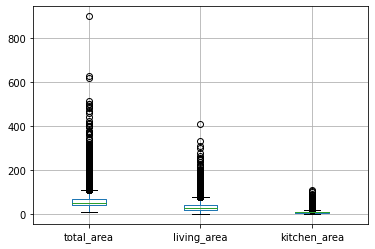

In [34]:
# посторим графики boxplot для площадей помещений
data.boxplot(column=['total_area', 'living_area', 'kitchen_area'])
plt.show;

По таким графикам сложно точно назвать границы "усов ящика", так что посчитаем эти значения отдельно.

In [35]:
# для 'total_area'
Q1 = data['total_area'].quantile(0.25)
Q3 = data['total_area'].quantile(0.75)
IQR = Q3 - Q1
print('Нижний 1,5*IQR ус:',Q1 - IQR * 1.5,'\nВерхний 1,5*IQR ус:', Q3 + IQR * 1.5)

Нижний 1,5*IQR ус: -3.0500000000000043 
Верхний 1,5*IQR ус: 111.75


In [36]:
# для 'living_area'
Q1 = data['living_area'].quantile(0.25)
Q3 = data['living_area'].quantile(0.75)
IQR = Q3 - Q1
print('Нижний 1,5*IQR ус:',Q1 - IQR * 1.5,'\nВерхний 1,5*IQR ус:', Q3 + IQR * 1.5)

Нижний 1,5*IQR ус: -17.400000000000002 
Верхний 1,5*IQR ус: 77.80000000000001


In [37]:
# для 'kitchen_area'
Q1 = data['kitchen_area'].quantile(0.25)
Q3 = data['kitchen_area'].quantile(0.75)
IQR = Q3 - Q1
print('Нижний 1,5*IQR ус:',Q1 - IQR * 1.5,'\nВерхний 1,5*IQR ус:', Q3 + IQR * 1.5)

Нижний 1,5*IQR ус: -0.35000000000000053 
Верхний 1,5*IQR ус: 19.25


Используем вычисленные значения в дальнейшем для фильтрации датафрейма.

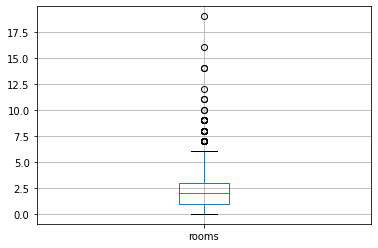

In [38]:
# посторим графики boxplot для количества комнат в квартире
data.boxplot(column=['rooms'])
plt.show;

Исходя из данных на графике, возьмем для фильтрации максимальное значение количества комнат в квартире равное 6.

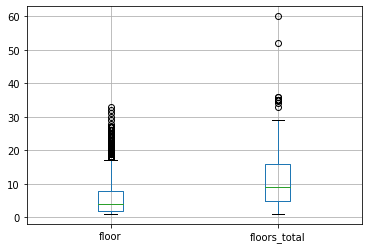

In [39]:
# посторим графики boxplot для этажа и общего количества этажей в доме
data.boxplot(column=['floor', 'floors_total'])
plt.show;

Используем для фильтрации максимальное значение этажей - 29.

In [40]:
# отфильтруем наши данные относительно всех обозначеных выше критериев
data_new = data.query('(total_area <= 112)\
                        & (living_area <= 78)\
                        & (kitchen_area <= 20)\
                        & (rooms <= 6)\
                        & (floors_total <= 29)').reset_index(drop=True)

In [41]:
# проверим, что в данных нет квартир на этажах, которые бы имели значение больше, чем указанное в фильтре для 'floors_total'
data_new.floor.max()

27

In [42]:
# посчитаем, сколько данных мы суммарно потеряли на этапе удаления выбросов 
data_new.shape[0]/df_row_number * 100

90.31190324633991

~9.7% данных было в итоге потеряно на этапе устранения редких и выбивающихся значений. 

### 3. Посчитайте и добавьте в таблицу новые столбцы

In [43]:
# цена одного квадратного метра
data_new['price_per_m2'] = data_new['last_price']/data_new['total_area']

In [44]:
# день недели публикации объявления
data_new['exposition_weekday'] = data_new['first_day_exposition'].dt.weekday

In [45]:
# месяц публикации объявления
data_new['exposition_month'] = data_new['first_day_exposition'].dt.month

In [46]:
# год публикации объявления
data_new['exposition_year'] = data_new['first_day_exposition'].dt.year

In [47]:
# тип этажа квартиры
def floor_type(row):
    if  row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
data_new['floor_type'] = data_new.apply(floor_type, axis=1)

In [48]:
# расстояние до центра города в километрах
data_new['cityCenters_nearest_km'] = (data_new['cityCenters_nearest']/1000).round(0)

In [49]:
# посмотрим на итоговый датафрейм
data_new.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,exposition_weekday,exposition_month,exposition_year,floor_type,cityCenters_nearest_km
0,7,3350000.0,40.4,2018-12-04,1,2.615,11,18.6,1,False,...,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
1,10,5196000.0,56.0,2015-08-20,2,2.700,5,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,14.0
2,10,2890000.0,30.4,2018-09-10,1,2.650,12,14.4,5,False,...,NaN,NaN,NaN,55.0,95065.789474,0,9,2018,другой,NaN
3,6,3700000.0,37.3,2017-11-02,1,2.640,26,10.6,6,False,...,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,другой,19.0
4,5,7915000.0,71.6,2019-04-18,2,2.700,24,30.5,22,False,...,NaN,0.0,NaN,NaN,110544.692737,3,4,2019,другой,12.0


### 4. Проведите исследовательский анализ данных

#### 4.1. Изучите параметры объектов

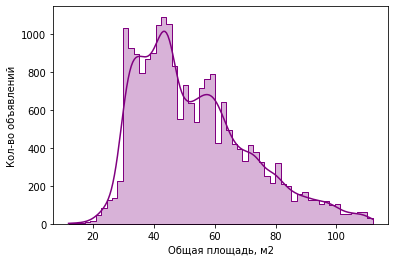

In [50]:
# общая площадь
sns.histplot(data=data_new, x="total_area", kde=True, element="step", color="purple", alpha=.3)
plt.ylabel('Кол-во объявлений', fontsize=10)
plt.xlabel('Общая площадь, м2', fontsize=10);

Большинство квартир, выставленных на продажу, имеют общую площадь от 30 до 50 м2. С ростом значения общей площади квартиры количество предложений падает.

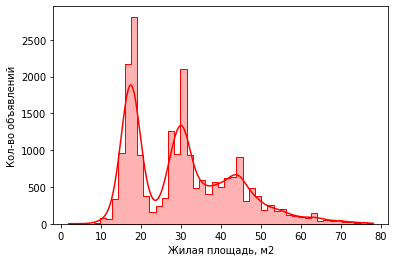

In [51]:
# жилая площадь
sns.histplot(data=data_new, x="living_area", kde=True, element="step", color="red", alpha=.3)
plt.ylabel('Кол-во объявлений', fontsize=10)
plt.xlabel('Жилая площадь, м2', fontsize=10);

Можно выделить три четких пика в распределении параметра жилой площади - это значения около 18, 30 и 45 м2. В промежутках между этими значениями парметра жилой площади наблюдается значительное уменьшения количества доступных для покупки предложений.

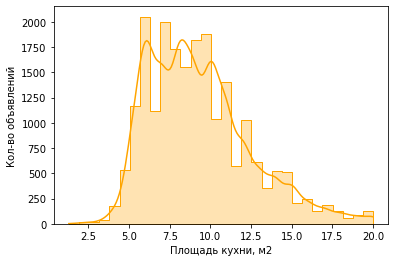

In [52]:
# площадь кухни
sns.histplot(data=data_new, x="kitchen_area", kde=True, element="step", color="orange", alpha=.3, bins=30)
plt.ylabel('Кол-во объявлений', fontsize=10)
plt.xlabel('Площадь кухни, м2', fontsize=10);

Параметр "Площадь кухни" характеризуется неравномерностью распределения. Наблюдается тенденция к воспроизведению формы распределения параметра "Общая площадь". Это не удивительно, ведь для заполнения пропусков в данных неизвестные значения параметра "Площадь кухни" заменялись вычисленными нами отнсительно общей площади квартиры.

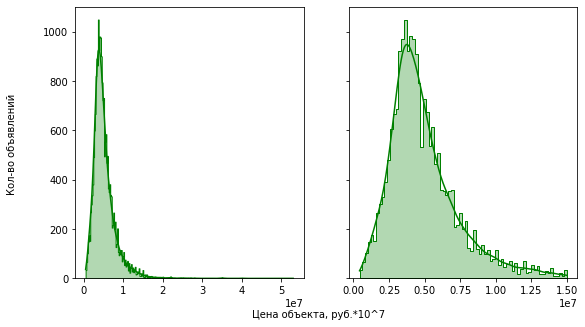

In [53]:
# цена объекта
f, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
g1 = sns.histplot(data=data_new, x="last_price", kde=True, element="step", color="green", alpha=.3, ax=axes[0])
g2 = sns.histplot(data=data_new[data_new['last_price']<=15000000], x="last_price", kde=True, element="step", color="green", alpha=.3,  ax=axes[1])
g1.set(xlabel=None)
g1.set(ylabel=None)
g2.set(xlabel=None)
g2.set(ylabel=None)
f.supxlabel('Цена объекта, руб.*10^7', fontsize=10)
f.supylabel('Кол-во объявлений', fontsize=10)
plt.show;

Левый график описывает общих характер распределения параметра "Цена объекта". Так как эти данные предварительно не фильтровались на этапе предобработки, мы можем наблюдать длинный "хвост" из очень дорогих редких предложений продажи. Для упрощения восприяти основной массы данных справа представлена часть графика, ограниченная по цене продажы до 15 млн. руб. График распределения стремится к нормальному виду. Наибольшее количество предложений сосредоточено в диапазоне от ~2,5 млн. до ~6 млн. руб.  

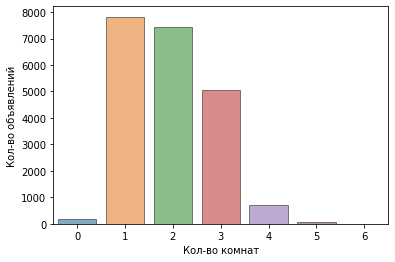

In [54]:
# количество комнат
sns.barplot(data=data_new, x=data_new.rooms.value_counts().index, y=data_new.rooms.value_counts(), alpha=.6, edgecolor='.2')
plt.ylabel('Кол-во объявлений', fontsize=10)
plt.xlabel('Кол-во комнат', fontsize=10);

Самый распространенный вариант квартир, выставляемых на продажу - однокомнатные. Следующий по популярности - двухкомнатные. Также в данных представлено порядка 5 тыс. предложений продажи трехкомнатных квартир. Предложения продажи квартир с большим числом комнат встречаются редко (что не удивительно, какие планировки в целом более редкие). 

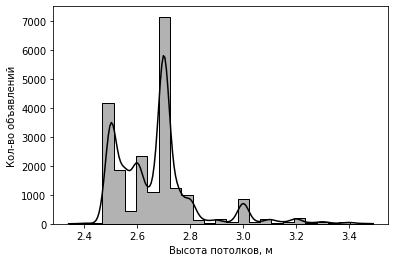

In [55]:
# высота потолков
sns.histplot(data=data_new, x="ceiling_height", kde=True, element="step", color="black", alpha=.3, bins=27)
plt.ylabel('Кол-во объявлений', fontsize=10)
plt.xlabel('Высота потолков, м', fontsize=10);

Наиболее распространенной высотой потолков является значение в 2.7 м. Стоит отметить, правда, что наши данные не отражают реальную картину происходящего, а являются лишь предположением, так как из-за большого количества пропусков в исходных данных (более 9000 незаполеных ячеек "ceiling_height"), отсутствующие данные заполняли медианами, которые как раз приходятся на значение 2.7.

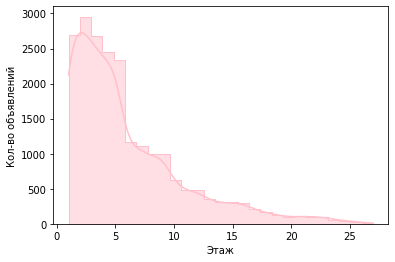

In [56]:
# этаж квартиры
sns.histplot(data=data_new, x="floor", kde=True, element="step", color="pink", alpha=.5, bins=27)
plt.ylabel('Кол-во объявлений', fontsize=10)
plt.xlabel('Этаж', fontsize=10);

Большая часть квартир, представленных в базе, располагается между 1 и 5 этажами. Дальше, с увеличением номера этажа, количество предложений уменьшается. Определяется это в первую очередь тем, что в нашей базе представлено много предложений о продаже квартир из домов высотой до 10 этажей (см. график "общее количество этажей в доме" ниже).

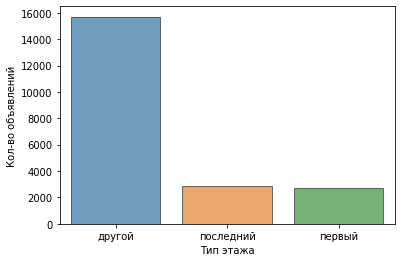

In [57]:
# тип этажа квартиры («первый», «последний», «другой»)
sns.barplot(data=data_new, x=data_new.floor_type.value_counts().index, y=data_new.floor_type.value_counts(), alpha=.7, edgecolor='.2')
plt.ylabel('Кол-во объявлений', fontsize=10)
plt.xlabel('Тип этажа', fontsize=10);

Предложения продажи квартир на первом и на последнем этажах зданий в наших данных представленные практически в равном объеме.

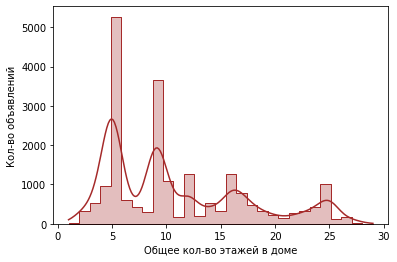

In [58]:
# общее количество этажей в доме
sns.histplot(data=data_new, x="floors_total", kde=True, element="step", color="brown", alpha=.3, bins=29)
plt.ylabel('Кол-во объявлений', fontsize=10)
plt.xlabel('Общее кол-во этажей в доме', fontsize=10);

Основная масса квартир на продажу находится в зданиях высотой 5 и 9 этажей. Можно предположить, что это дома старой советской застройки. 

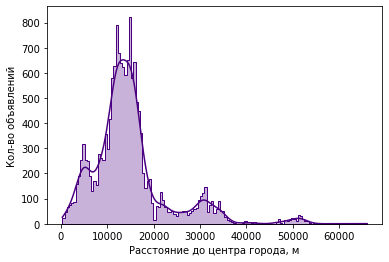

In [59]:
# расстояние до центра города в метрах
sns.histplot(data=data_new, x="cityCenters_nearest", kde=True, element="step", color="indigo", alpha=.3)
plt.ylabel('Кол-во объявлений', fontsize=10)
plt.xlabel('Расстояние до центра города, м', fontsize=10);

Большая часть квартир, выставленных на продажу, находится на расстоянии до 20 км от центра Санкт-Петербурга (в черте города).

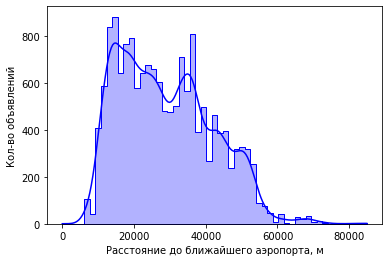

In [60]:
# расстояние до ближайшего аэропорта
sns.histplot(data=data_new, x="airports_nearest", kde=True, element="step", color="blue", alpha=.3)
plt.ylabel('Кол-во объявлений', fontsize=10)
plt.xlabel('Расстояние до ближайшего аэропорта, м', fontsize=10);

В основном, квартиры из базы имеют близлижайший аэропорт на расстоянии 10-50 км.

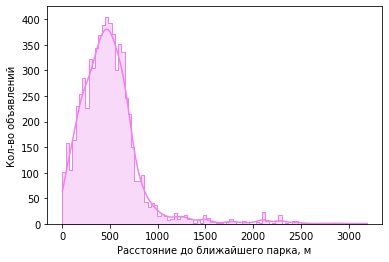

In [61]:
# расстояние до ближайшего парка
sns.histplot(data=data_new, x="parks_nearest", kde=True, element="step", color="violet", alpha=.3)
plt.ylabel('Кол-во объявлений', fontsize=10)
plt.xlabel('Расстояние до ближайшего парка, м', fontsize=10);

Подавляющее большенство квартир из базы имеют близлижайший парк на расстоянии 200-800 м.

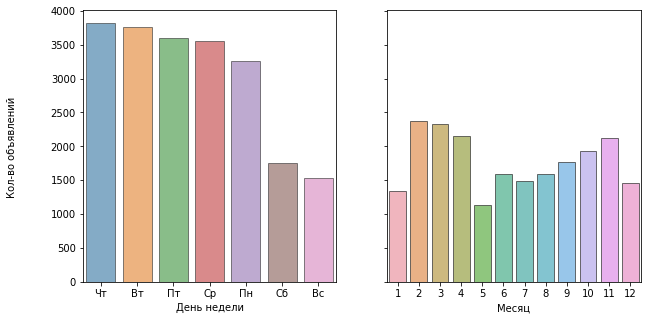

In [62]:
# поменяем значения в колонке 'exposition_weekday' с чисел на названия дней недели для удобства чтения графика
data_new1 = data_new.replace({'exposition_weekday':{0:'Пн', 1:'Вт', 2:'Ср', 3:'Чт', 4:'Пт', 5:'Сб', 6:'Вс'}})

# день недели и месяц публикации объявления
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
g1 = sns.barplot(data=data_new1, x=data_new1.exposition_weekday.value_counts().index, y=data_new1.exposition_weekday.value_counts(), alpha=.6, edgecolor='.2', ax=axes[0])
g2 = sns.barplot(data=data_new, x=data_new.exposition_month.value_counts().index, y=data_new.exposition_month.value_counts(), alpha=.7, edgecolor='.2', ax=axes[1])
g1.set(xlabel='День недели')
g1.set(ylabel=None)
g2.set(xlabel='Месяц')
g2.set(ylabel=None)
f.supylabel('Кол-во объявлений', fontsize=10)
plt.show;

Пользователи предпочитают выставлять объявления о продаже квартир в будние дни. При этом понедельник является наименее популярным будним днем для заполнения объявления о продаже квартиры среди пользователей. 
<br>
Наибольшее количество предложений о продаже квартир появляется в конце зимы и весной (февраль, марти и апрель). К лету количество новых предложений резко падает. Осенью наблюдается постепенный рост новых предложений продажи квартир. В декабре и январе (предположительно, в связи с празднованием Нового Года) количество объявлений о продаже значительно уменьшается. 

#### 4.2. Изучите, как быстро продавались квартиры

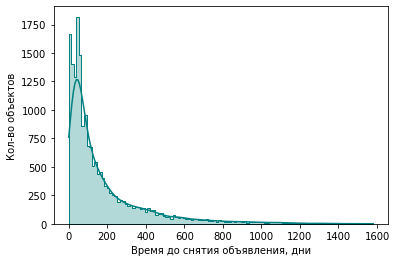

In [63]:
# построим гистограму для 'days_exposition'
sns.histplot(data=data_new, x="days_exposition", kde=True, element="step", color="teal", alpha=.3)
plt.ylabel('Кол-во объектов', fontsize=10)
plt.xlabel('Время до снятия объявления, дни', fontsize=10);

In [64]:
median_days_exposition = data_new.days_exposition.describe()[5]
mean_days_exposition = data_new.days_exposition.describe()[1]
print(f'Медиана days_exposition: {median_days_exposition} день \nСреднее days_exposition: {mean_days_exposition} дня')

Медиана days_exposition: 91.0 день 
Среднее days_exposition: 173.49324541653266 дня


***
**ВЫВОД:** Медианное значение времени снятия объявления - 91 день. Это говорит о том, что примерно половина всех квартир к этому времени уже продана (или пользователь снял объявление по другой причине). Таким образом можно считать, что продажи, совершенные быстрее чем за 3 месяца являются быстрыми (Q1 = 44 дня). В свою очередь, если объявление не было снято к 7 месяцу (Q3 = 219 дней), такая продажа является медленной. Если объявление не было снято к ~480 дню, такую продажу можно считать необычайно долгой. 

#### 4.3. Какие факторы больше всего влияют на общую (полную) стоимость объекта?

In [65]:
# для last_price посчитаем корреляции с другими количественными переменными
data_corr = data_new[['total_area', 'living_area', 'kitchen_area', 'rooms', 'last_price']]
data_corr.corr().last_price

total_area      0.681899
living_area     0.542528
kitchen_area    0.516512
rooms           0.397324
last_price      1.000000
Name: last_price, dtype: float64

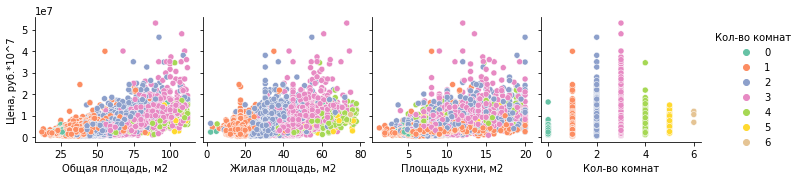

In [66]:
# построим графики зависимости параметра 'last_price' от 'total_area', 'living_area', 'kitchen_area' и 'rooms'
data_corr = data_corr.rename(columns={'total_area': 'Общая площадь, м2',
                                      'living_area': 'Жилая площадь, м2',
                                      'kitchen_area': 'Площадь кухни, м2',
                                      'rooms':'Кол-во комнат',
                                      'last_price': 'Цена, руб.*10^7'})

sns.pairplot(
    data=data_corr, 
    hue='Кол-во комнат',
    palette='Set2',
    x_vars=['Общая площадь, м2', 'Жилая площадь, м2', 'Площадь кухни, м2', 'Кол-во комнат'], 
    y_vars='Цена, руб.*10^7'
);

Обнаружена средняя положительная корреляция параметра 'last_price' и параметра 'total_area'; средняя положительная корреляция параметра 'last_price' и параметра 'living_area'; средняя положительная корреляция параметра 'last_price' и параметра 'kitchen_area'; слабая положительная корреляция параметра 'last_price' и параметра 'rooms'.

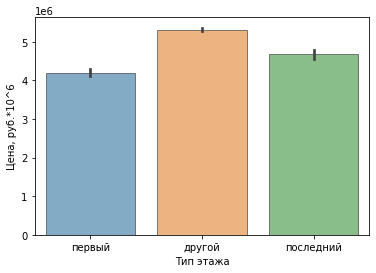

In [67]:
# построим графики зависомости параметра 'last_price' от 'floor_type'
sns.barplot(data=data_new, x='floor_type', y='last_price', alpha=.6, edgecolor='.2')
plt.ylabel('Цена, руб.*10^6', fontsize=10)
plt.xlabel('Тип этажа', fontsize=10);

Из данных на графике видно, что цена квартир, расположенных на первом этаже, меньше, чем у квартир этажами выше. При этом цена квартир на последнем этаже также оказывается меньше, чем цена квартир на других этажах дома (кроме первого). 

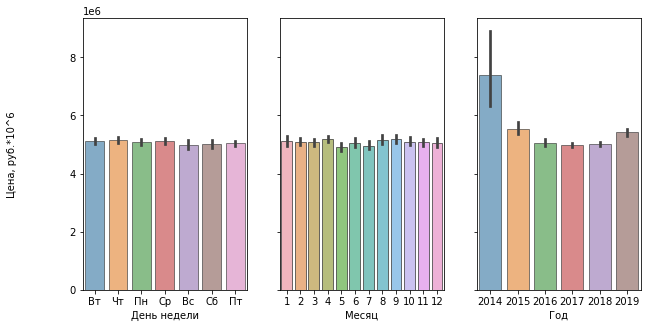

In [68]:
# построим графики зависимости параметра 'last_price' от 'exposition_weekday', 'exposition_month' и 'exposition_year'
f, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
g1 = sns.barplot(data=data_new1, x='exposition_weekday', y='last_price', alpha=.6, edgecolor='.2', ax=axes[0])
g2 = sns.barplot(data=data_new, x='exposition_month', y='last_price', alpha=.7, edgecolor='.2', ax=axes[1])
g3 = sns.barplot(data=data_new, x='exposition_year', y='last_price', alpha=.6, edgecolor='.2', ax=axes[2])
g1.set(xlabel='День недели')
g1.set(ylabel=None)
g2.set(xlabel='Месяц')
g2.set(ylabel=None)
g3.set(xlabel='Год')
g3.set(ylabel=None)
f.supylabel('Цена, руб.*10^6', fontsize=10)
plt.show;

In [69]:
# посчитаем t-статистику для средних цен на недвижимость в 2018 и 2019 годах
cat1 = data_new[data_new['exposition_year']==2018]
cat2 = data_new[data_new['exposition_year']==2019]

ttest_ind(cat1['last_price'], cat2['last_price'])
# заранее учтем, что предположение о независимости выборок и равенстве дисперсий может быть нарушено

Ttest_indResult(statistic=-5.9810294979571, pvalue=2.290515604759109e-09)

Исходя из данных, представленных на графике, видно, что ни день недели, ни месяц, ни год публикации объявления в целом не сильно влияют на цену. Однако, стоит отметить аномально высокую цену на недвижимость в 2014 году. 
> *Экономический кризис 2014 года можно назвать новым этапом рецессии и продолжением кризиса 2008 года. [ ] Рынок недвижимости отреагировал на очередной виток кризиса так же, как и в предыдущие годы: сокращением спроса, снижением темпов строительства, уменьшением рублевых цен, которые с учетом падения уровня жизни фактически выросли для большинства покупателей.*
<br>
**Сергей Велесевич** // Три российских кризиса: как падал рынок жилья в 1998, 2008 и 2014 годах.
https://realty.rbc.ru/news/5b76c9fb9a79471f1c1c81db

<br>
В связи с отсутствием в данных информации за 2020 и 2021 года, мы не можем точно утверждать (подтверждая суждения реальными данными), существует ли тренд на увеличение стоимости недвижимости в последние годы (видим <u>статистически значимое увеличение</u> цены в 2019 году по сравнению с 2018).
    
***
**ВЫВОД:** 
+ Обнаруживается положительная корреляция между площадью квартир (общая площадь, жилая площади, площадь кухни) и полной стоимостью объекта. 
+ Количество комнат в квартире слабо коррелирует со стоимостью. 
+ Из данных видно, что квартиры, расположенные не на первом или последнем этажах здания, стоят дороже. 
+ Дата публикации не оказывает существенного влияния на цену. 
+ Самым непредсказуемым, но в тоже время одним из наиболее значимых факторов, влияющих на стоимость недвижимости, является экономическая и политическая обстановка в стране, а также экономические кризисы.

#### 4.4. Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [70]:
# для решения задачи воспользуемся группировкой и аггрегацией
top_locality_name_by_price_per_m2 = data_new\
                                            .groupby('locality_name', as_index=False)\
                                            .agg({'open_plan': 'count','price_per_m2': 'mean'})\
                                            .sort_values(by='open_plan', ascending=False)\
                                            .rename(columns={'locality_name': 'Населенный пункт', 
                                                             'price_per_m2': 'Средняя цена за м2, руб.', 
                                                             'open_plan': 'Кол-во объявлений'})\
                                            .round(2)\
                                            .reset_index(drop=True)\
                                            .head(10)

display(top_locality_name_by_price_per_m2)

,Населенный пункт,Кол-во объявлений,"Средняя цена за м2, руб."
0,Санкт-Петербург,13742,108988.43
1,Мурино,577,86115.62
2,Кудрово,449,95567.88
3,Шушары,430,78540.12
4,Всеволожск,386,68475.96
5,Колпино,332,75387.72
6,Пушкин,329,101048.61
7,Парголово,324,90296.93
8,Гатчина,299,68870.34
9,Выборг,215,57992.83


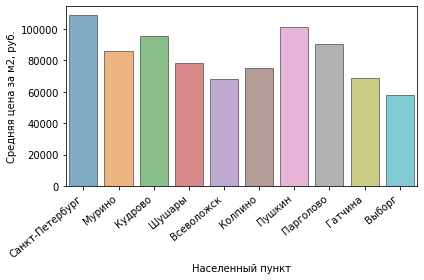

In [71]:
# построим столбчатую диаграмму для найденых 10 населённых пункттов
ax = sns.barplot(data=top_locality_name_by_price_per_m2, x='Населенный пункт', y='Средняя цена за м2, руб.', alpha=.6, edgecolor='.2')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout();

На графике можно видеть топ 10 населенных пунктов по количеству объявлений о продаже недвижимости и среднюю стоимость 1 м2 в каждом населенном пункте.

#### 4.5. Вычислите среднюю цену м2 недвижимости для каждого километра в Санкт-Петербурге

In [72]:
# для решения этой задачи построим сводную таблицу
mean_km_price = data_new[data_new['locality_name']=='Санкт-Петербург']\
        .rename(columns={'cityCenters_nearest_km': 'Расстояние до центра, км', 'price_per_m2': 'Средняя цена за м2, руб.'})\
        .pivot_table(index='Расстояние до центра, км', values='Средняя цена за м2, руб.', aggfunc='mean')\
        .reset_index()\
        .round(2)

display(mean_km_price)

,"Расстояние до центра, км","Средняя цена за м2, руб."
0,0.0,179245.55
1,1.0,134656.65
2,2.0,140735.73
3,3.0,116081.01
4,4.0,125364.74
5,5.0,133128.29
6,6.0,131324.91
7,7.0,130838.37
8,8.0,120711.69
9,9.0,110310.02


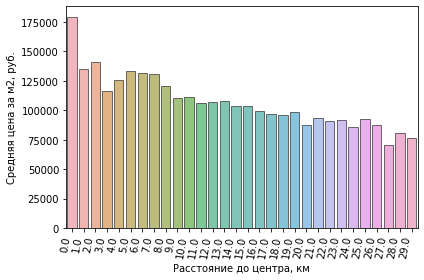

In [73]:
# построим столбчатую диаграмму
ax = sns.barplot(data=mean_km_price, x='Расстояние до центра, км', y='Средняя цена за м2, руб.', alpha=.7, edgecolor='.2')
ax.set_xticklabels(ax.get_xticklabels(), rotation=80, ha="right")
plt.tight_layout();

По данным на графике можно наблюдать как изменяется цена 1 м2 недвижимости по мере удаления от центра Санкт-Петербурга.

### Общий вывод:

Предоставленные для анализа данные из архива объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет были предварительно обработаны перед работой: 
+ удалены строки с пропусками в полях "общее количество этажей" и "название населенного пункта" (суммарно 135 строк);
+ пропукси в колонке  "количество балконов" заменены на 0 (11519 значений);
+ пропуски значений "высота потолков" заполнены медианными значениями для конкретных населенных пунктов (9100 значений);
+ пропуски в столбце "жилая площадь" заполнены медианным значением в соответствии с количеством комнат в квартире (1903 значения);
+ пропущенные значения "площадь кухни" заполнены исходя из пересчетного коэффициента 0.174 относительно значений столбца "общая площадь квартиры" (2278 значений);
+ пропуски в столбце "является ли апартаментами" заменены на False (20924 значения);
+ удалены 59 неявных дубликата в названиях населенных пунктов;
+ в общей сложности, на этапе предобработки потеряно ~9.7% данных.

<br>
В результате представленного исследования были выделены ключевые параметры, на которые стоит обращать внимание при построении аналитической системы скрининга объявлений:

1. **Общая площадь помещения, жилая прощадь, площадь кухни**
<br>Данные параметры положительно коррелируют с ценой объекта недвижимости (R>0.5).
2. **Населенный пункт и удаленность от центра города**
<br>Самые высокие средние цены за м2 обнаружены в г. Санкт-Петербурге, г. Пушкине, г. Кудрово и пос. Парголово (>90 тыс. за м2). Стоимость объекта недвижимости тем выше, чем ближе он располагается к центру города.
3. **Количество комнат в квартире**
<br>Наибольшая стоимость отмечается у трех- и двухкомнатных квартир, следом идут однокомнатные и четырехкомнатные.
4. **Тип этажа, на котором расположена квартира (первый, последний, другой)** 
<br>Квартиры на первом и последнем этажах стоят меньше.
5. **Общая экономическая ситуация в стране**
<br>Необходимо изначально определять, существует ли тренд к росту цен на недвижимость в текущем году по сравнению с предыдущими.

<br>
В ходе проведенного исследования было также обнаружено:

+ Большинство квартир, выставленных на продажу, имеют общую площадь от 30 до 50 м2.
+ Наибольшее количество предложений сосредоточено в диапазоне от ~2,5 млн. до ~6 млн. руб.
+ Ни день недели, ни месяц, ни год публикации объявления не оказывает существенного влияния на цену.
+ Наибольшее количество предложений о продаже квартир появляется в конце зимы и весной (февраль, марти и апрель).
+ Обнаружено статистически значимое увеличение цены на объекты недвижимости в 2019 году по сравнению с 2018 (p-level t-критерия много меньше 0.05)
+ Медианное значение времени снятия объявления - 91 день. Если объявление не было снято к ~480 дню, такую продажу можно считать необычайно долгой.